[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/niteshjindal170988/unsupervised-learning/blob/main/clustering/k_means_clustering.ipynb)



# Import Packages

In [1]:
import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import math
from copy import deepcopy
from collections import Counter
import warnings
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
import os
warnings.filterwarnings("ignore")
#os.getcwd()

In this exercise, we will follow the following steps:
-  PCA on [Digit Recognizer Dataset](https://www.kaggle.com/c/digit-recognizer) to get the top-30 projections/dimensions that captures the maximum variance of  data.<br>
- K Means Clustering on PCA output (i.e. 30 features data). Define 10 clusters to partition the data.<br>
    - K Means Clustering on the subset of Data.<br>
    - K Means Clustering on the entire Dataset.
Details on PCA can be checked here [PCA-wikipage](https://en.wikipedia.org/wiki/Principal_component_analysis) and the notebook on PCA in the same repository- [PCA notebook](https://github.com/niteshjindal170988/unsupervised-learning/blob/main/dimensionality-reduction/principal_component_analysis_digit_recognizer.ipynb) 


# PCA on the Digit-Recognizer Data

## Download Dataset from Google Drive


In [ ]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org gdown==4.2.0
import gdown
warnings.filterwarnings("ignore")
# Load digit-recognizer (Train Data)
url = 'https://drive.google.com/uc?id=1SfSO5ZloHH3W6GJa5rfy9-qwjG4YPbM4'
output = 'train.csv'
gdown.download(url, output, quiet=False, verify=False)

You should consider upgrading via the 'c:\users\ag89382\appdata\local\programs\python\python37\deepenv\scripts\python.exe -m pip install --upgrade pip' command.


Downloading...
From: https://drive.google.com/uc?id=1SfSO5ZloHH3W6GJa5rfy9-qwjG4YPbM4
To: C:\Users\AG89382\AppData\Local\Programs\Python\Python37\deepenv\tutorials\unsupervised-learning\clustering\train.csv
 96%|██████████████████████████████████████████████████████████████████████████▌   | 73.4M/76.8M [01:34<00:04, 755kB/s]

# Read Dataset

In [2]:
data = pd.read_csv("train.csv")
display(data.head()) #  Digits / Pixel data
print(data.shape)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 785)


The data set-`train.csv` has 785 columns. The first column, called `label`, which is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
There are 10 labels (0 to 9).

Let's get started!

# Define a Class PCA to get the Projections

In [3]:
class PCA:
    #lbl_col_index=0 # global variable ; column index/position having class labels.
    def __init__(self, df, lbl_col_index=0):
    
        '''
        Declare instance variables
        '''
        self.df=df  
        self.lbl_col_ind=lbl_col_index
        self.labels = pd.Series(self.df.iloc[:,self.lbl_col_ind]).unique() #unique target labels 
        self.labelseries = pd.Series(self.df.iloc[:,self.lbl_col_ind])
#         print(self.labels)
        
    def drop_target_column(self, dataframe):
        features= dataframe.drop(dataframe.iloc[:,self.lbl_col_ind:self.lbl_col_ind+1], axis=1)
        return features
            
        
        
    def subset_data(self, uniq_trgt_lbl:int = None):
        '''
        Takes an integer value as an input (numeric category label).
        Returns-
        (1) Pandas Dataframe which is scaled subset of data without labels 
        (2) Pandas Series of Labels 
        Standard Scaler returns values with zero mean and unit variance.
        '''
        if uniq_trgt_lbl is None:
            subdf = self.df
        else:
            subdf=self.df[self.df.iloc[:,self.lbl_col_ind] == self.labels[uniq_trgt_lbl]]
            
        catg = subdf.iloc[:,self.lbl_col_ind]
        features = self.drop_target_column(subdf)
        return features, catg
    
    
    def feature_scaling(self, features):
        scaled_features=StandardScaler(copy=True, with_mean=True).fit_transform(features)
        return scaled_features
        
        
    def cov_mat(self, uniq_trgt_lbl: int=None):
        '''
        Takes in the unique target label to filter the data.
        Returns the scaled data of dimensions (4132, 784) 
        and the covariance matrix of scaled data of dimensions (784, 784).
        '''
        if uniq_trgt_lbl is None:
            subdf=self.drop_target_column(self.df)
            scaled_feat=self.feature_scaling(subdf)
            covmat = np.cov(scaled_feat, rowvar = False, bias = False)
            return scaled_feat, covmat
        else:
            subdf=self.subset_data(uniq_trgt_lbl)[0] #get the scaled features 
            scaled_feat=self.feature_scaling(subdf)
            covmat = np.cov(scaled_feat, rowvar = False, bias = False)
            return scaled_feat, covmat
         

    def eig_val_eig_vec(self, covariance_matrix):
        
        '''
        Takes input as square array / covariance matrix
        and returns pairs of eigen value and eigen vector of the
        covariance matrix in descending value of eigen value.
        '''
        
        eigval, eigvec = np.linalg.eig(covariance_matrix)
        pairs_eigval_eigvec = [(np.abs(eigval[k]), eigvec[:,k]) for k in range(len(eigval))]
        sorted_eg_ev_pairs = sorted(pairs_eigval_eigvec, key=lambda rw: rw[0], reverse=True)  
        return sorted_eg_ev_pairs 
    
    def visualize_explained_variance(self, covariance_matrix):
        information=self.eig_val_eig_vec(covariance_matrix)
        eigval= [i[0] for i in information] #array containing eigen values sorted in descending order
        var_exp = [(i/sum(eigval)) for i in eigval] 
        cum_sum_exp = np.cumsum(var_exp) #cummulative explained variance 
    
        plt.step(range(0,len(cum_sum_exp)),
                 cum_sum_exp,
                 where='mid',
                 label='Cumulative explained variance')
        
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
    def extract_n_principal_components(self, covariance_matrix, reqno_of_pcs):
        
        '''
        Horizontally stacks the top two eigen vectors ordered based on
        descending eigen values
        '''
            
        srtd_eg_ev_pair = self.eig_val_eig_vec(covariance_matrix)
        stacked_cmpnts=[np.hstack((k[1].reshape(784,1))) for k in srtd_eg_ev_pair[0:reqno_of_pcs]]
        stacked_arr=np.asarray(stacked_cmpnts).T
        return stacked_arr
    
    def get_projected_data(self, scaleddata, covariance_matrix, reqno_of_pcs):
        '''
        Takes the covariance matrix of dimensions D*D 
        Computes the Dot Product of scaled data for cat0 -> (4132*784)
        with the eigen vectors of Covariance Matrix  with highest eigen values (784*2)
        Return the projected data set of dimensions (m*2) for example for cat0->(4132*2)
        '''
        stcked_cmpnts = self.extract_n_principal_components(covariance_matrix, reqno_of_pcs)
        projecteddata=pd.DataFrame(scaleddata.dot(stcked_cmpnts))
        projecteddata.columns = ["PC_" + str(col) for col in projecteddata.columns]
        return projecteddata

# Extract the Top-30 Principal Components 

In [4]:
# uniq_categories=sorted(data.label.unique())
#create PCA instance (object)
pca_instance=PCA(data, 0)  ## 0 is the column index of labels in the data.
scaled_dat, covmatr=pca_instance.cov_mat()
PCA_30=pca_instance.get_projected_data(scaled_dat, covmatr, 30)
PCA_30['label'] = pca_instance.labelseries
PCA_30

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,label
0,-5.140478,-5.226445,3.887001,-0.901512,-4.929111,-2.035413,-4.706946,4.767184,-0.230958,-1.460962,...,1.282251,1.390834,1.033241,-2.450662,-0.025323,-0.543821,-2.181736,1.114760,-0.497239,1
1,19.292332,6.032996,1.308148,-2.383294,-3.095188,1.791095,3.772790,-0.153865,4.115192,-4.299357,...,3.397149,0.212285,-0.220914,0.623992,-4.191473,-0.001298,0.070117,-0.246701,-1.783818,0
2,-7.644503,-1.705813,2.289326,2.241135,-5.094426,4.152058,1.012004,-1.732559,-0.436261,-0.073687,...,0.925756,-2.307804,-1.882139,2.069934,-0.594148,-1.129816,-1.538711,0.583776,0.248477,1
3,-0.474207,5.836139,2.008617,4.271106,-2.377777,-2.179913,-4.398030,0.353712,-0.992308,5.501253,...,-1.099471,-0.531728,-0.489333,-3.446940,-1.623493,-0.844744,0.505766,0.655911,0.779984,4
4,26.559574,6.024818,0.933179,-3.012645,-9.489179,2.331195,6.149597,1.783637,4.123302,-5.757361,...,-0.842493,0.868689,-0.167608,2.809954,-3.381034,-1.239311,0.041742,-1.488019,-0.685522,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,13.678849,-1.350366,-3.957336,-5.379672,-10.875898,5.105523,-0.071920,5.084014,4.253677,-0.673734,...,-1.519416,1.800787,2.581044,-0.835002,0.791062,1.092196,0.969723,-4.285741,-1.025209,0
41996,-8.869582,-1.187360,2.323167,1.528830,-5.798988,2.821950,0.351780,-0.529810,-0.992204,-1.126098,...,2.021420,-2.783751,-1.306372,1.845894,-0.297738,-0.217034,-0.036322,0.339123,1.303649,1
41997,0.495391,7.076277,-12.089700,-3.223278,-0.618203,-0.330449,2.128035,-10.535164,2.225962,-1.881028,...,2.868081,-0.034297,-2.166629,-3.650243,-3.068946,2.451997,-0.601931,-0.825128,-2.011762,7
41998,2.307240,-4.344513,0.699848,10.011222,5.586478,5.494875,-0.189789,-5.450360,-2.181693,-1.767516,...,-1.260995,2.777467,-0.797147,0.717561,-2.477200,1.701241,2.232109,-0.524232,2.044783,6


<br><br>Clustering is the grouping of similar things. There are various clustering methods, for example-
<br>
![image](https://raw.githubusercontent.com/niteshjindal170988/unsupervised-learning/main/clustering/.scrap/clus0.JPG)
<br>
**K means clustering** is a type of Partitional Clustering. Let us say that we have n different data points $x_{1}, x_{2} \ldots x_{n}$ and K different clusters, such as   $\mathrm{m}_{1}, \mathrm{~m}_{2} \ldots \mathrm{m}_{\mathrm{k}}$. For every combination of data point and a cluster, we can compute a distance between them, for example the distance between $x_1$ and $m_1$ or distance between $x_1$ and $m_k$ and so on.
Minimizing the distance between nth data point and kth cluster can be written as:
$\left(x_n-m_k\right)^2$                           
<br>
However, every data point is not associated with every cluster. Thus, we need to associate the nth data point with the cluster it belongs to, not all the clusters. We will define a latent variable $\delta_{n,k}$ that tells us whether the nth datapoint is associated with cluster K or not. $\delta_{n,k}$ either 0 or 1. If it is 1, then the distance between the nth datapoint and kth cluster matters else not. <br><br>
Therefore, we write the objective function as:
<br><br>
$J(m)=\sum_{n} \sum_{k} \delta_{n, k}\left(\left\|x_{n}-m_{k}\right\|\right)^{2}$
<br>
<br>
**Params**	**Term**	**Definition**<br><br>
K	= Hyperparameter	= Number of Clusters <br><br>
$m_k$	= Parameters	= Cluster Mean Vectors.<br><br>
$D\ast k$	= Total Number of Parameters.	Each $m_k$ is a D-dimensional vector and hence its matrix size is $D\ast k$. Thus, the learned parameters are $D\ast k$<br><br>
$\delta_{n,k}$	= Latent Parameter<br><br>
$\delta_{n,k}$ that have value of 1 when there is an association between nth datapoint and a particular cluster. For all other combinations, the value would be 0. Latent parameter are similar to parameters, but we need them so as to write the objective function in a simple way.<br>
<br> 
Hyperparameter tell us the complexity of the modelling system.
<br><br>
What makes $\delta_{n,k}$ a latent parameter?
<br>
We learned that the size of $\delta_{n,k}$ is  $n\ast k$ and size of $m_k$ is $D\ast k$ . If we know $\delta_{n,k}$ , we can compute $m_k$ because we know that each datapoint is associated with a particular cluster only, and thus we can obtain the all the datapoints belonging to a particular cluster and take their mean to get cluster mean vector or cluster centers. So, the latent parameters are equivalent to parameters ( $m_k$ )
<br>
We can alternate between the $\delta_{n,k}$ and  ${\bar{m}}_k$  ( i.e. $\delta_{n,k}$ is given and known to us and we compute ${\bar{m}}_k$ , or ${\bar{m}}_k$ is given and we compute $\delta_{n,k}$).  In the following lines, we will consider $\delta_{n,k}$ as constant and update the ${\bar{m}}_k$ -
<br><br>
Steps:<br>

-1 Cluster Assignment: Randomly Initialize The Cluster Centers
<br>
![image](https://raw.githubusercontent.com/niteshjindal170988/unsupervised-learning/main/clustering/.scrap/clus1.JPG)
<br>
-2 Compute the association of each Datapoint with each Cluster center (Euclidean distance). If distance of a datapoint is nearest to a particular cluster, map the datapoint to that cluster and assign $\delta_{n,k}$ = 1 <br><br>
-3 Recompute the Cluster Centers.
<br>
![image](https://raw.githubusercontent.com/niteshjindal170988/unsupervised-learning/main/clustering/.scrap/clus2.JPG)
<br>
We keep altering between the step 2 and step 3 until the convergence is met. 
<br><br>
Let us derive the Cluster Centers:<br><br>
$J(m, \delta)=\sum_{n=1}^{N} \sum_{k=1}^{k} \delta_{n, k}\left(\bar{m}_{k}-\bar{x}_{n}\right)^{2}$
<br><br>Keep  $\delta_{n,k}$ as constant and update the ${\bar{m}}_j$. We take the partial derivative w.r.t ${\bar{m}}_j$ (i.e., jth cluster):<br><br>
=> $\frac{\partial J}{\partial m_{j}}=2 \sum_{n=1}^{N} \delta_{n,j}\left(\bar{m}_{j}-\bar{x}_{n}\right)=0$<br><br>
=> $\sum_{n=1}^{N} \delta_{n,j} \cdot m_{j}$ = $\sum_{n=1}^{N} \delta_{n,j} \bar{x}_{n}$<br><br>
=> $\mathbf{m}_{k}^{(t+1)} = \frac{\sum_{n=1}^{N} \delta_{n, k}^{(t)} \mathbf{X}^{n}}{\sum_{n=1}^{N} \delta_{n, k}^{(t)}}$

<br><br>
Output of k means clustering is a set of mean vectors. 






# Let's get started ! 

## K-means Clustering on the PCA_30
<br>
We initialize the random clusters initially and then **iterate** of the datapoints and number of clusters until the convergence is achieved.Therefore, K Means Clustering is an **Iterative Method** as opposed to Closed Form of Solution Method, and is **Non-Deterministic**  as opposed to Deterministic, because the output depends on the initialization of random clusters in the K-means clustering.  Farthest first point initialization with K means clusterings makes the K-means Clustering somewhat deterministic, but if we do randomly initialize first point or density based sampling gives random or non-deterministic output. 
<br><br>
Minimum number of clusters can be one (i.e. all datapoints in a single cluster) and maximum number of clusters can be equal to the number of datapoints in the data. As we **increase the complexity** i.e., the number of clusters,there would be an **increase in accuracy**. Model **memorizes** When the number of cluster becomes equal to number of datapoints, the accuracy is 100%. <br><br>

<br><br>**In the following exercise, we will build 10 clusters and examine the effect of initialization on clusters-** 

# Define kmeans() 

Apply k means clustering on batch of data. Each batch is a subset of data filtered with class label. 

In [98]:
def kmeans(K, D: int, N: int, batch, cls_labelname):
    '''
    K is the number of clusters, D and N are batch dimensions and rows. 
    Batch is a subset of the data filtered with class label.
    '''
    
    cluster_centers_T = np.zeros(shape=(D, K))  

    #generate random vectors
    for num in range(0, batch.shape[1]):
        random.seed(num)
        rv= random.sample(range(int(np.mean(batch) - 4.5*np.std(batch)), int(np.mean(batch) + 5.5*np.std(batch))), K)
        cluster_centers_T[num] = rv

    m_k = np.transpose(cluster_centers_T) # each of the 10 cluster centers is a 30 - dimensional vector.
    m_k # cluster centers shape is (K * D) 
    m_k_initialization_matrix = np.zeros(m_k.shape) #  shape is (K*D) 

    #The linalg norm() function returns the norm of the given matrix or vector.
    #Matrix norm measures the size of a matrix. 
    err = np.linalg.norm(m_k- m_k_initialization_matrix) 
    print("\nError during first farther point initialization is {}\n".format(err))
    iters_to_converge = 0
    while err!=0:    
        # dictionary contains information about best cluster corresponding to a datapoint in batch
        datapoint_cluster_mapping_dict= dict() 
        delta_n_k = np.zeros(shape=(N, K)) #shape is (N*K)
        for rw in range(len(batch)):
              #get the euclidean distance between each batch row and all the k=10 cluster centers. 
            delta_n_k[rw] = np.linalg.norm(x = batch[rw] - m_k, keepdims = False,  axis=1) # (10,)
            datapoint_cluster_mapping_dict[rw] = np.argmin(delta_n_k[rw]) 
        datapoint_cluster_mapping_dict  

        m_k_initialization_matrix = deepcopy(m_k)

        for cluster in range(0, K): #seggregate the datapoints within each cluster. 
            cluster_density = [batch[row] for row in range(len(batch)) if datapoint_cluster_mapping_dict[row] == cluster]
            m_k[cluster] = np.nan_to_num(np.mean(np.array(cluster_density), axis=0)) # take mean of datapoints in cluster
        err = np.linalg.norm(m_k - m_k_initialization_matrix)
        if err <= 0.01:
            iters_to_converge += 1
            #print("\nError in iteration {} is {}\n".format(iters_to_converge, err))
            break;
        else:
            iters_to_converge += 1
            #print("\nError in iteration {} is {}".format(iters_to_converge, err))
        
    print("\nError in iteration {} is {}\n".format(iters_to_converge, err))
    if cls_labelname is None:
        data_cluster_mapping=datapoint_cluster_mapping_dict
        return data_cluster_mapping
    
    else:
        inv_datapoint_cluster_mapping_dict =sorted(
          Counter(datapoint_cluster_mapping_dict.values()).items())
        
        output=pd.DataFrame(inv_datapoint_cluster_mapping_dict, 
                                columns = ("cluster_number", "datapoints_cnt")
                                    ).assign(iters_to_converge=(iters_to_converge)
                                            ).assign(class_label=cls_labelname)
        return output

# K Means Clustering on entire Dataset PCA_30


Shape of the Batch is  (42000, 30)

Cluster  5

Error during first farther point initialization is 109.69503179269333


Error in iteration 49 is 0.0054282108863108

Purity of Cluster 5 is 0.366452380952381 


Cluster  10

Error during first farther point initialization is 164.76650144977893


Error in iteration 38 is 0.005011769715313935

Purity of Cluster 10 is 0.44011904761904763 


Cluster  15

Error during first farther point initialization is 205.64046294443125


Error in iteration 195 is 0.009082811843355429

Purity of Cluster 15 is 0.5405714285714286 


Cluster  20

Error during first farther point initialization is 233.18447632722038


Error in iteration 145 is 0.00894668506469954

Purity of Cluster 20 is 0.5145238095238095 


Cluster  25

Error during first farther point initialization is 256.81900241220467


Error in iteration 74 is 0.0

Purity of Cluster 25 is 0.5703809523809524 



<AxesSubplot:xlabel='Cluster Number'>

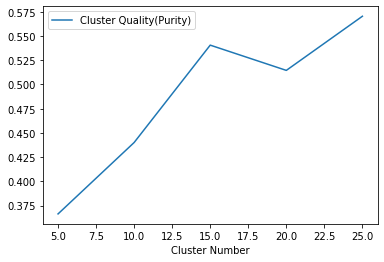

In [102]:
# kmeansobj=PCA(PCA_30, 30)  # label column position in PCA_30 is 30th
unq_labels = kmeansobj.labels # 10 unique labels in the digits data
f, c = kmeansobj.subset_data(None) 

batch=f.values
D=batch.shape[1]
N=batch.shape[0]
print("\nShape of the Batch is ", (N,D))
Kluster=[5,10,15,20,25]
cluster_quality_purity = []
for K in Kluster: #range(15, 16):
    print("\nCluster ", K)
    outp_d2c_mapping=kmeans(K, D, N, batch, None)
    outp_mapping_dict=[(outp_d2c_mapping[obs_ind], obs_ind, c[obs_ind])
                       for obs_ind in outp_d2c_mapping]
    # pd.set_option('display.max_rows', None)
    dat=pd.DataFrame(outp_mapping_dict, columns = ["cluster", "observation", "actual_label"])
    cls_cnt = dat.groupby(['cluster', 'actual_label']).count()['observation']
    tot_cnts_all_cluster = 0
    max_cnts_per_cluster=0
    for k in range(K):
        #print(np.argmax(cls_cnt[k]))  # get the class with maximum counts in a cluster
        tot_cnts_all_cluster = tot_cnts_all_cluster + np.sum(cls_cnt[k])
        try:
            max_cnts_per_cluster = max_cnts_per_cluster + cls_cnt[k][np.argmax(cls_cnt[k])]
        except KeyError:
            max_cnts_per_cluster = max_cnts_per_cluster + cls_cnt[k][np.argmax(cls_cnt[k])+1]

    purity = (max_cnts_per_cluster/tot_cnts_all_cluster)
    cluster_quality_purity.append(purity)
    print("Purity of Cluster {} is {} \n".format(K, purity))
    
    
'''Plot Cluster vs Purity:- '''
Kluster=list([5,10,15,20,25])
cluster_eval=pd.DataFrame(zip(Kluster, cluster_quality_purity),
                         columns =['Cluster Number', 'Cluster Quality(Purity)'])
cluster_eval.plot(x='Cluster Number', y='Cluster Quality(Purity)', kind='line')


<br>we see the increase in purity with the increase in number of cluster centers.
<br>

# K Means Clustering on subsets of Dataset PCA_30

In [8]:
#create kmeansobj instance 
kmeansobj=PCA(PCA_30, 30)  # label column position in PCA_30 is 30th
unq_labels = kmeansobj.labels # 10 unique labels in the digits data

# #iteration on class label 
# subclass, cls_label = kmeansobj.subset_data(0)  #subset data with label = 0 
# batch = subclass.values # batch has shape N*30. dimensions = 30 (after PCA).

#define global parameters
K = 10 # number of clusters as per user requirement (user defined)
# D = batch.shape[1]  # dimensions = 30 
# N = batch.shape[0]  # sample datapoints = N 
output_summary = pd.DataFrame()
for cls_labelname in unq_labels:
    print("\nK means on Sample with class label {}".format(cls_labelname))
    subclass, cls_label = kmeansobj.subset_data(cls_labelname)  #subset data with label = 0 
    batch = subclass.values # batch has shape N*30. dimensions = 30 (after PCA).
    D = batch.shape[1]  # dimensions = 30 
    N = batch.shape[0]  # sample datapoints = N 
    outp=kmeans(K, D, N, batch, cls_labelname)
    output_summary=pd.concat([output_summary,outp],axis=0)

pd.set_option('display.max_rows', None)
output_summary=output_summary.reset_index()

output_summary.head(100)


K means on Sample with class label 1

Error during first farther point initialization is 186.95721435665433


Error in iteration 1 is 173.8816968232656


Error in iteration 2 is 18.879588078232057


Error in iteration 3 is 9.750444488378397


Error in iteration 4 is 5.48953508097156


Error in iteration 5 is 3.691137671266259


Error in iteration 6 is 3.3148633348351417


Error in iteration 7 is 2.8999781401001417


Error in iteration 8 is 2.4029316034049057


Error in iteration 9 is 1.7602241527387585


Error in iteration 10 is 1.3553015768483598


Error in iteration 11 is 1.1173191327691872


Error in iteration 12 is 1.1215159145664158


Error in iteration 13 is 1.1297611455422192


Error in iteration 14 is 1.1116144381372275


Error in iteration 15 is 1.1310223566334894


Error in iteration 16 is 0.9737026132865807


Error in iteration 17 is 0.7907872998388763


Error in iteration 18 is 0.7908996775966198


Error in iteration 19 is 1.0104492894737516


Error in iteration 20 is 0.98


Error in iteration 71 is 0.05652160392627956


Error in iteration 72 is 0.06210483351861136


Error in iteration 73 is 0.04196076536471564


Error in iteration 74 is 0.08769058242325443


Error in iteration 75 is 0.09435031449064028


Error in iteration 76 is 0.10811469646881124


Error in iteration 77 is 0.11054759779956533


Error in iteration 78 is 0.10161630235071274


Error in iteration 79 is 0.08146450138931588


Error in iteration 80 is 0.0871539936811382


Error in iteration 81 is 0.07102405646860149


Error in iteration 82 is 0.13971828501668007


Error in iteration 83 is 0.1437066822626444


Error in iteration 84 is 0.15465992054089855


Error in iteration 85 is 0.14034504324093713


Error in iteration 86 is 0.20083294873653504


Error in iteration 87 is 0.14162995569500822


Error in iteration 88 is 0.17428877190451939


Error in iteration 89 is 0.06818277200594522


Error in iteration 90 is 0.09768242574830074


Error in iteration 91 is 0.0


K means on Sample with class l


Error in iteration 41 is 0.33872453588996915


Error in iteration 42 is 0.37649675559396534


Error in iteration 43 is 0.3714872200519606


Error in iteration 44 is 0.29853980939670505


Error in iteration 45 is 0.2210007164995618


Error in iteration 46 is 0.25112278145258593


Error in iteration 47 is 0.2836576468932699


Error in iteration 48 is 0.2495603028495625


Error in iteration 49 is 0.23736963061225283


Error in iteration 50 is 0.1667755137847913


Error in iteration 51 is 0.2271614634753751


Error in iteration 52 is 0.04634368209788699


Error in iteration 53 is 0.0656890763674779


Error in iteration 54 is 0.09319739731911629


Error in iteration 55 is 0.026857451843471585


Error in iteration 56 is 0.03093154271706225


Error in iteration 57 is 0.026153793888803956


Error in iteration 58 is 0.03802349829165362


Error in iteration 59 is 0.0287368323260648


Error in iteration 60 is 0.0


K means on Sample with class label 9

Error during first farther point initializa


Error in iteration 35 is 0.08579030808359242


Error in iteration 36 is 0.039239445071466844


Error in iteration 37 is 0.03527675898889235


Error in iteration 38 is 0.039564739825373244


Error in iteration 39 is 0.04158497990164971


Error in iteration 40 is 0.028825535866630933


Error in iteration 41 is 0.03679545013514565


Error in iteration 42 is 0.0


K means on Sample with class label 6

Error during first farther point initialization is 132.495282934903


Error in iteration 1 is 123.16377330761757


Error in iteration 2 is 20.796181859888968


Error in iteration 3 is 9.98298472533129


Error in iteration 4 is 5.625053936513202


Error in iteration 5 is 3.3110471725758654


Error in iteration 6 is 2.2415955005588883


Error in iteration 7 is 1.4399081451843176


Error in iteration 8 is 1.200429699915984


Error in iteration 9 is 0.9130350624059272


Error in iteration 10 is 0.7660277035869871


Error in iteration 11 is 0.8100172032808788


Error in iteration 12 is 0.70432727

,index,cluster_number,datapoints_cnt,iters_to_converge,class_label
0,0,0,300,36,1
1,1,1,393,36,1
2,2,2,504,36,1
3,3,3,470,36,1
4,4,4,429,36,1
5,5,5,203,36,1
6,6,6,457,36,1
7,7,7,376,36,1
8,8,8,441,36,1
9,9,9,559,36,1
